<a href="https://colab.research.google.com/github/Userfound404/GSoC-QMLHEP-Tasks/blob/main/QMLHEP_GSoC'24_Task_II_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task II

you will use ParticleNet's data for Quark/Gluon jet classification available here with its corresponding description.
- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.
- Discuss the resulting performance of the 2 chosen architectures.



In [ ]:
!pip install dgl

# 1. Introduction

We have to Perform Quark/Gluon jet classification on ParticleNet’s data for using Graph Neural Network (GNN)

So, we wil be using the `dgl` (deep graph library) package for constructing GNN models

In [ ]:
# load some basic packages first
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

# 2. Create Graph Representation of Data

References:

How to create a graph  https://docs.dgl.ai/tutorials/basics/1_first.html

How to assign features to edges:  https://docs.dgl.ai/guide/training-edge.html

### Load Data

The dataset contains:

- 50k quark and 50k gluons with constitutes (charged or neural tracks) of the jets

- Each jet is represented by a four-dimensional vector: $p_T, y, \phi$, and PDGid.

In [ ]:
if 'google.colab' in str(get_ipython()):
  !wget https://zenodo.org/record/3164691/files/QG_jets.npz

--2024-03-25 08:43:32--  https://zenodo.org/record/3164691/files/QG_jets.npz
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3164691/files/QG_jets.npz [following]
--2024-03-25 08:43:32--  https://zenodo.org/records/3164691/files/QG_jets.npz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M  8.09MB/s    in 18s     

2024-03-25 08:43:51 (5.58 MB/s) - ‘QG_jets.npz’ saved [106689379/106689379]



In [ ]:
data = dict(np.load('QG_jets.npz', allow_pickle=True))
X, y = data['X'], {'label': torch.tensor(data['y']).long()}
print('Dimension of input data: {}'.format(X.shape))

Dimension of input data: (100000, 139, 4)


### Create Graph Representation of Data

A graph can have features in three different places or levels:

- features for nodes
- features for edges
- features for the whole graph

A **jet** is **encoded as a graph**.

The **label** of whether it is a quark or a gluon is **encoded as the graph feature**.

Each constitute (**track**) is encoded as a **node** of the graph, with the **four-dimensional vector** as its **node features**.

Features are preprocessed to reflect a centred jets and normalised $p_T$ according to Eqn 3.1 of the original paper (https://arxiv.org/abs/1810.05165).

**Nodes** are **connected by bi-directional edges** if they are **adjacent** in either $p_T, y, \phi$.

This ensures that each graph is connected.

**Nodes index** are **ordered in descending order of $p_T$**.

In [ ]:
import dgl
import networkx as nx
from dgl.data.utils import save_graphs, load_graphs

# https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

class GenerateGraphs(object):
    def describe(self): return self.__class__.__name__
    def __init__(self, data, connect_style):
        '''
          Args:
            data: np.ndarry
              input data
            connect_style: str
              Type of edge connections
        '''
        self.data = data
        self.label_name = 'label'
        self.feature_name = 'feature'
        self.connect_style = connect_style
        self._current_data = None

    def _assign_node_feature(self, graph):
        ''' Each node presents a b-jet with four momentum and b-tagging score as features.
        '''
        feature_name = 'feature'
        assert(self._current_data is not None)
        graph.ndata[feature_name] = torch.tensor(self._current_data)
        return graph

    def _create_graph(self, ievent: int):
        ''' Create a graph from a jet X [track multiplicity, "4-momentum"], where "4-momentum" is pt, rapidity, azimuthal angle, and pdgid.
            data: https://zenodo.org/record/3164691#.YFeQey1Q0lp
        '''
        self._current_data = self.data[ievent][~np.all(self.data[ievent] == 0, axis=1)]

        ''' Feature preprocessing: Sect 3.1 in https://arxiv.org/pdf/1810.05165.pdf
            centering jets and normalizing pT
            https://energyflow.network/examples/
        '''
        yphi_avg = np.average(self._current_data[:,1:3], weights=self._current_data[:,0], axis=0)
        self._current_data[:,1:3] -= yphi_avg
        self._current_data[:, 0] /= np.sum(self._current_data[:, 0])

        ''' - Sort by pT (0th column) '''
        self._current_data = self._current_data[self._current_data[:,0].argsort()][::-1].copy()

        ''' Construct a graph '''
        n_nodes = self._current_data.shape[0] # track multiplicity
        if self.connect_style == 'bifully':
            ''' Option 1: Fully connected graph '''
            g = nx.complete_graph(n_nodes)
            graph = dgl.from_networkx(g)
        else:
            ''' Option 2: Bi-directional connection in adjacent track in pT or eta or phi'''
            pt_order = self._current_data[:,0].argsort()[::-1]
            rapidity_order = self._current_data[:,1].argsort()[::-1]
            eta_order = self._current_data[:,2].argsort()[::-1]

            if self.connect_style == 'biadj_pt_y_phi':
                in_node  = np.concatenate((pt_order[:-1], rapidity_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], rapidity_order[1: ], eta_order[1: ]))
            elif self.connect_style == 'biadj_pt_y':
                in_node  = np.concatenate((pt_order[:-1], rapidity_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], rapidity_order[1: ]))
            elif self.connect_style == 'biadj_pt_phi':
                in_node  = np.concatenate((pt_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], eta_order[1: ]))
            elif self.connect_style == 'biadj_y_phi':
                in_node  = np.concatenate((rapidity_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((rapidity_order[1: ], eta_order[1: ]))

            g = dgl.graph(( in_node, out_node), num_nodes=n_nodes)
            g = dgl.add_reverse_edges(g)
            graph = dgl.add_self_loop(g)


        ''' Assign node feature using "current data" '''
        graph = self._assign_node_feature(graph)

        return graph.int() # 32-bit integers for node and edge IDs to reduce memory

    def create_graphs(self, stop=None):
        ''' Create all graphs for all events.
        '''

        ''' PDGid to small float dictionary https://github.com/pkomiske/EnergyFlow/blob/master/energyflow/utils/data_utils.py#L188 '''
        PID2FLOAT_MAP = {22: 0,
                    211: .1, -211: .2,
                    321: .3, -321: .4,
                    130: .5,
                    2112: .6, -2112: .7,
                    2212: .8, -2212: .9,
                    11: 1.0, -11: 1.1,
                    13: 1.2, -13: 1.3,
                    0: 0,}
        for pid in np.unique(self.data[:, :, 3].flatten()):
            np.place(self.data[:, :, 3], self.data[:, :, 3] == pid, PID2FLOAT_MAP[pid])

        graphs = []
        n_graphs = min(stop, self.data.shape[0]) if stop else self.data.shape[0]

        for i in range(n_graphs):
            if i % 1000 == 0:
                print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', f'\033[92mCreated {self.connect_style} graphs:\033[0m'.rjust(40, ' '),  i, '/', n_graphs)
            graph = self._create_graph(i)
            graphs.append(graph)
        return graphs

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


In [ ]:
# Let's connect the nodes if they are adjacent in either $p_T, y, \phi$.
generator = GenerateGraphs(X, connect_style='biadj_pt_y_phi')
graphs = generator.create_graphs()
graph_file_name = 'QG_jets_{connection}.bin'
save_graphs(graph_file_name, graphs, y)

2024-03-25 08:44:04 [INFO]  Created biadj_pt_y_phi graphs: 0 / 100000
2024-03-25 08:44:06 [INFO]  Created biadj_pt_y_phi graphs: 1000 / 100000
2024-03-25 08:44:07 [INFO]  Created biadj_pt_y_phi graphs: 2000 / 100000
2024-03-25 08:44:09 [INFO]  Created biadj_pt_y_phi graphs: 3000 / 100000
2024-03-25 08:44:11 [INFO]  Created biadj_pt_y_phi graphs: 4000 / 100000
2024-03-25 08:44:13 [INFO]  Created biadj_pt_y_phi graphs: 5000 / 100000
2024-03-25 08:44:15 [INFO]  Created biadj_pt_y_phi graphs: 6000 / 100000
2024-03-25 08:44:16 [INFO]  Created biadj_pt_y_phi graphs: 7000 / 100000
2024-03-25 08:44:18 [INFO]  Created biadj_pt_y_phi graphs: 8000 / 100000
2024-03-25 08:44:19 [INFO]  Created biadj_pt_y_phi graphs: 9000 / 100000
2024-03-25 08:44:21 [INFO]  Created biadj_pt_y_phi graphs: 10000 / 100000
2024-03-25 08:44:23 [INFO]  Created biadj_pt_y_phi graphs: 11000 / 100000
2024-03-25 08:44:24 [INFO]  Created biadj_pt_y_phi graphs: 12000 / 100000
2024-03-25 08:44:26 [INFO]  Created biadj_pt_y_phi 

### Visualize the graph

In [ ]:
def plot_graph(graph):
    print('Number of nodes and edges: {} / {}'.format(graph.number_of_nodes(), graph.number_of_edges()))
    nx.draw(graph.to_networkx(), with_labels=True, node_color=[[.7, .7, .9]])
    plt.show()

Number of nodes and edges: 15 / 99


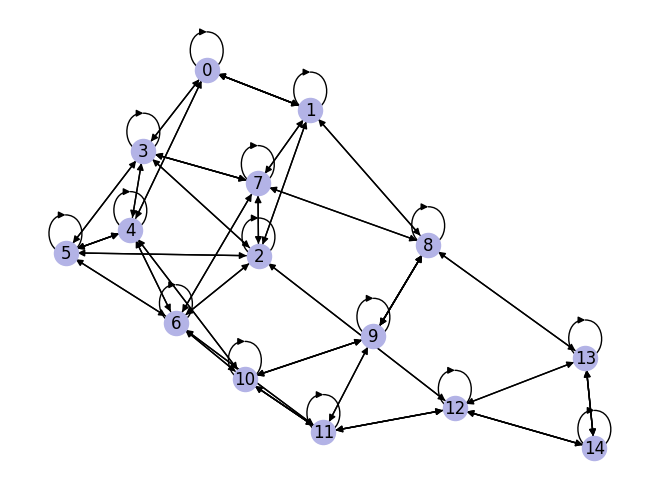

In [ ]:
# take the first graph as an example
plot_graph(graphs[2024])

So for this particular jet, there are 18 constituents

### Prepare dataset for training, validation and test

- We will split the data into training, validation and test dataset according to the ratios 60:20:20

In [ ]:
train_size = int(len(graphs) * 0.6)
val_size = int(len(graphs) * 0.2)
test_size = len(graphs) - train_size - val_size

dataset = list(zip(graphs, y['label']))
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_size, val_size, test_size))

# since the training is very slow, just let batch size be 1
train_dataloader = dgl.dataloading.GraphDataLoader(train_dataset, batch_size = train_size, drop_last=False, shuffle=True)
val_dataloader = dgl.dataloading.GraphDataLoader(val_dataset, batch_size = val_size, drop_last=False, shuffle=False)
test_dataloader = dgl.dataloading.GraphDataLoader(test_dataset, batch_size = test_size, drop_last=False, shuffle=False)

print('Train size: ', train_size)
print('Validation size: ', val_size)
print('Test size: ', test_size)

Train size:  60000
Validation size:  20000
Test size:  20000


# 3. Implementing Graph Neural Network Models

Suppose we have a graph $G$ with $n$ nodes and $m$ edges. We have\
$X$ is the feature matix for the nodes\
$A$ is the adjacency matrix of the graph $G$\
$\tilde{A}=A+I_n$ is the adjacency matrix with added self-loops\
$\tilde{D}_{ij} = \sum_{k} \tilde{A}_{ik}\delta_{ij}$ is the diagonal degree matrix\
$\mathcal{N}$ is the neighborhood function\
$W$ is the weight matrix

The essence of a GNN architecture is in its node representation $H^K$ where $K$ is the depth/iteraction.

We will be looking at two architectures

- **GCN** (Graph Convolutional Network) (https://arxiv.org/abs/1609.02907): \
$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$\
where $\sigma$ is an activation function


- **GAT** (Graph Attention Network) (https://arxiv.org/pdf/1710.10903.pdf): \
$H^{\ell+1}_i = \sum_{j\in \mathcal{N}(i)}\alpha_{i,j}W^{(\ell)}H_j^{\ell}$\
where $\alpha_{i,j}$ is the attention score bewteen node $i$ and node $j$:\
$\alpha_{ij}^{l} = \mathrm{softmax_i} (e_{ij}^{l})$\
$e_{ij}^{l} = \mathrm{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)$


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
from dgl.nn.pytorch.conv import GraphConv


# class SGC(nn.Module):
#     '''
#         https://docs.dgl.ai/api/python/nn.pytorch.html?highlight=sageconv#sgconv
#     '''
#     def __init__(self, in_feats, hid_feats, out_feats):
#         super().__init__()
#         self.conv1 = dglnn.SGConv(in_feats=in_feats, out_feats=hid_feats)
#         self.conv2 = dglnn.SGConv(in_feats=hid_feats, out_feats=out_feats)

#     def forward(self, graph, inputs):
#         # inputs are features of nodes
#         h = self.conv1(graph, inputs)
#         h = F.elu(h)
#         h = self.conv2(graph, h)
#         h = torch.sigmoid(h)
#         return h

# class SAGE(nn.Module):
#     ''' Two layers of Inductive Representation Learning on Large Graphs.
#         https://docs.dgl.ai/api/python/nn.pytorch.html#sageconv
#     '''
#     def __init__(self, in_feats, hid_feats, out_feats):
#         super().__init__()
#         self.conv1 = dglnn.SAGEConv(in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
#         self.conv2 = dglnn.SAGEConv(in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

#     def forward(self, graph, inputs):
#         # inputs are features of nodes
#         h = self.conv1(graph, inputs)
#         h = F.elu(h)
#         h = self.conv2(graph, h)
#         h = torch.sigmoid(h)
#         return h

class GAT(nn.Module):
    ''' Two layers of Graph Attention Network.
        https://docs.dgl.ai/api/python/nn.pytorch.html#gatconv
    '''
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        # input shape = (nodes, features=in_feats); output shape = (nodes, num_head, hid_feats)
        self.gatconv1 = dglnn.GATConv(in_feats, hid_feats, num_heads=2)
        # input shape = (nodes, hid_feats * num_heads_previous_layer); output shape = (nodes, num_head, out_feats)
        self.gatconv2 = dglnn.GATConv(hid_feats * 2, out_feats, num_heads=1)

    def forward(self, graph, inputs):
        # input shape = (nodes , features)
        # print('inputs', inputs.shape, inputs)
        h = self.gatconv1(graph, inputs)
        # here h shape = (nodes, num_head, hid_feats)
        # print('h1', h.shape, h)
        ''' Reshape h to flatten the num_heads '''
        # here h shape = (nodes, num_head * hid_feats)
        h = h.reshape(h.shape[0], np.prod(h.shape[1:]))
        # print('h2', h.shape, h)
        h = self.gatconv2(graph, h)
        # print('h3', h.shape, h)

        graph.ndata['tmp_feature'] = h
        h = dgl.mean_nodes(graph, 'tmp_feature')
        # print('h4', h.shape, h)
        h = torch.sigmoid(h)
        h = torch.squeeze(h)
        # print('h9', h.shape, h)
        return h

# class AGNNConv(nn.Module):
#     ''' Graph Attention Network.
#         https://docs.dgl.ai/api/python/nn.pytorch.html#agnnconv
#     '''
#     def __init__(self):
#         super().__init__()

#     def forward(self, graph, inputs):
#         # inputs are features of nodes
#         h = AGNNConv()(graph, inputs)
#         h = torch.sigmoid(h)
#         return h

class GCN(nn.Module):
    ''' Graph Convolutional Network
        https://docs.dgl.ai/en/0.4.x/tutorials/basics/4_batch.html#graph-classification-tutorial
        https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/1_gcn.html
    '''
    def __init__(self, in_dim, hidden_dim, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, out_feats)
        self.bn1 = nn.BatchNorm1d(num_features=hidden_dim)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_dim)
        self.bn3 = nn.BatchNorm1d(num_features=out_feats)

    def forward(self, graph, h):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        # h = graph.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.bn1(self.conv1(graph, h)))
        h = F.relu(self.bn2(self.conv2(graph, h)))
        h = F.relu(self.bn3(self.conv3(graph, h)))
        graph.ndata['tmp_feature'] = h
        h = dgl.mean_nodes(graph, 'tmp_feature')
        # Calculate graph representation by averaging all the node representations.
        h = torch.sigmoid(h)
        h = (h-0.5) * 2
        return h

# class MLPPredictor(nn.Module):
#     def __init__(self, in_features, out_classes):
#         super().__init__()
#         self.W = nn.Linear(in_features * 2, out_classes)

#     def apply_edges(self, edges):
#         h_u = edges.src['h']
#         h_v = edges.dst['h']
#         score = self.W(torch.cat([h_u, h_v], 1))
#         return {'score': score}

#     def forward(self, graph, h):
#         # h contains the node representations computed from the GNN defined
#         # in the node classification section (Section 5.1).
#         with graph.local_scope():
#             graph.ndata['h'] = h
#             graph.apply_edges(self.apply_edges)
#             return graph.edata['score']

class GNNmodel(nn.Module):
    def __init__(self, module, in_features, hidden_features, out_features, name='GNN'):
        super().__init__()

        self.name = name

        if module.lower() == 'sage':
            # from dgl.nn import SAGEConv
            self.module = SAGE(in_features, hidden_features, out_features)
        elif module.lower() == 'gat':
            # from dgl.nn import GATConv
            self.module = GAT(in_features, hidden_features, out_features)
        elif module.lower() == 'agnnconv':
            # from dgl.nn import AGNNConv
            self.module = AGNNConv()
        elif module.lower() == 'sgc':
            # from dgl.nn import SGConv
            self.module = SGC(in_features, hidden_features, out_features)
        elif module.lower() == 'gcn':
            self.module = GCN(in_features, hidden_features, out_features)
        else:
            assert False, module + ' is not supported'

        # self.pred = MLPPredictor(out_features, 1)

    def forward(self, g, x):
        h = self.module(g, x)
        return torch.squeeze(h) #self.pred(g, h)

Some other important functions

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from datetime import datetime

# define training loop
def train(model, optimizer, epochs=100, loss_func=nn.MSELoss()):
    epoch_losses = {'train': [], 'val': []}
    epoch_accuracies = {'train': [], 'val': []}

    for epoch in range(epochs):
        train_loss = 0
        total_correct = 0
        total_samples = 0

        for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float())
            loss = loss_func(pred, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.detach().item()

            # Calculate accuracy
            predicted_labels = torch.round(pred)
            correct = (predicted_labels == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

        # The loss per epoch for all batches is the average of losses per batch in this epoch
        train_loss /= (ibatch + 1)

        # Calculate accuracy
        accuracy = total_correct / total_samples

        # Store loss and accuracy per epoch
        epoch_losses['train'].append(train_loss)
        epoch_accuracies['train'].append(accuracy)

        # Evaluate validation loss
        val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        for ibatch, (batched_graph, labels) in enumerate(val_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float())
            val_loss += loss_func(pred, labels.float()).detach().item()

            # Calculate accuracy
            predicted_labels = torch.round(pred)
            correct = (predicted_labels == labels).sum().item()
            total_correct_val += correct
            total_samples_val += labels.size(0)

            assert(ibatch == 0)

        val_loss /= (ibatch + 1)
        val_accuracy = total_correct_val / total_samples_val

        # Store validation loss and accuracy per epoch
        epoch_losses['val'].append(val_loss)
        epoch_accuracies['val'].append(val_accuracy)

        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', '\033[92mepoch, loss, val_loss, accuracy, val_accuracy:\033[0m'.rjust(40, ' '),  epoch+1, '|', train_loss, '|', val_loss, '|', accuracy, '|', val_accuracy)

    # Plotting
    plt.plot(epoch_losses['train'], label='Train Loss')
    plt.plot(epoch_losses['val'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(epoch_accuracies['train'], label='Train Accuracy')
    plt.plot(epoch_accuracies['val'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    return epoch_losses, epoch_accuracies


In [ ]:
 def test(model, loss_func=nn.MSELoss()):
    epoch_losses = {'test': []}
    with torch.no_grad():
        ''' Final Evaluate train loss '''
        train_pred = []
        train_labels = []
        for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            # print('zhangr train pred', pred.shape, pred)
            # print('zhangr train labels', labels.shape, labels)
            train_pred.append(pred)
            train_labels.append(labels)
        train_pred = torch.cat(train_pred).numpy()
        train_labels = torch.cat(train_labels).numpy()

        ''' Final Evaluate val loss '''
        val_pred = []
        val_labels = []
        for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            val_pred.append(pred)
            val_labels.append(labels)
            assert(ibatch == 0)
        val_pred = torch.cat(val_pred).numpy()
        val_labels = torch.cat(val_labels).numpy()


        ''' Evaluate test loss '''
        test_pred = []
        test_labels = []
        for ibatch, (batched_graph, labels) in enumerate(test_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            test_loss = loss_func(pred, labels.float()).detach().item()
            epoch_losses['test'].append(test_loss)
            test_pred.append(pred)
            test_labels.append(labels)
            assert(ibatch == 0)
        test_pred = torch.cat(test_pred).numpy()
        test_labels = torch.cat(test_labels).numpy()
    return epoch_losses, train_pred, train_labels, val_pred, val_labels, test_pred, test_labels

In [ ]:
# Plot the loss over time
def plot_loss(*losses, labels=None):
    plt.clf()
    fig = plt.figure(figsize=(10, 5))
    for loss in losses:
        plt.plot(loss)
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    if labels:
      plt.legend(labels, loc='upper right', fontsize=15)
    return plt

In [ ]:
# Plot the ROC curve
# this is taken from my own package `quple`
from typing import List
def plot_stacked_roc_curve(fpr_list:List[np.ndarray],
                   tpr_list:List[np.ndarray], labels:List[str]=None, title:str='ROC Curve', with_auc:bool=True):
    """Plots multiple roc curves stacked together

    Args:
        fpr: list/array of numpy array
            A collection of arrays containing the false positive rates for
            different experiments
        tpr: list/array of numpy array
            A collection of arrays containing the false positive rates for
            different experiments
        labels: list of str, default = None
            List of labels for different experiments.
        title: str, default = 'ROC Curve'
            Title of the plot
        with_auc: True or False
            Whether to include the auc in the labels

    Returns:
        A matplotlib plot of the stacked roc curve
    """
    assert len(fpr_list) == len(tpr_list)
    n = len(fpr_list)
    if labels is None:
        labels = ['']*n
    assert len(labels) == n
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    plt.clf()
    plt.rcParams["font.weight"] = "bold"
    plt.xlabel("Signal Efficiency", fontsize=18,fontweight='bold')
    plt.ylabel("Background Rejection", fontsize=18,fontweight='bold')
    plt.title(title, fontsize=16,fontweight='bold')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.grid(color='gray', linestyle='--', linewidth=1)
    for fpr,tpr,label in zip(fpr_list, tpr_list, labels):
        if with_auc:
            roc_auc = auc(fpr, tpr)
            label += ', AUC={:.4f}'.format(roc_auc)
        plt.plot(tpr,1-fpr, linestyle='-',label=label,linewidth=2)
    plt.plot([0, 1], [1, 0], linestyle='--', color='black', label='Luck, AUC= 0.5')
    plt.legend(loc='best',prop={'size': 8})
    return plt


def plot_roc_curve(fpr:np.ndarray, tpr:np.ndarray, label:str='', title:str='ROC Curve', with_auc:bool=True):
    """Plots a roc curve

    Args:
        fpr: numpy array
            An array containing the false positive rates
        tpr: numpy array
            An array containing the true positive rates
        label: str
            Label of the curve
        title: str
            Title of the plot
        with_auc: True or False
            Whether to include the auc in the labels

    Returns:
        A matplotlib plot of the roc curve
    """
    return plot_stacked_roc_curve([fpr], [tpr], [label], title=title, with_auc=with_auc)

## Architecture 1: Graph Convolution Network

Graph Convolutional networks apply the concept of convolutional neural networks (CNNs) to irregular data structures such as graphs. GCNs have grown in popularity due to their effectiveness in a variety of tasks, including node classification, link prediction, and graph classification.

Given a graph $G = (V, E)$ consisting of a set of nodes $V$ and a set of edges $E$, where each node $v_i$ is associated with a feature vector $x_i$.

Just like CNNs operate on each pixel of an image, GCNs act on the nodes i.e. to aggregate information from the neighbouring nodes for each node in the graph.

Let $ A $ be the adjacency matrix of the graph, where $ A_{ij} = 1 $ if there is an edge between nodes $ v_i $ and $ v_j $, and $ 0 $ otherwise. Let $ H^{(l)} $ be the representation matrix of nodes at layer $ l $, where each row represents the feature vector of a node. The operation of a single layer in a GCN can be formulated as follows:
$$
H^{(l+1)} = \sigma\left(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}\right)
$$

Where
 - $ H^{(l)} $ is the input node features at layer $ l $.
    - $ W^{(l)} $ is the weight matrix for layer $ l $.
    - $ \tilde{A} = A + I $ is the adjacency matrix of the graph with self-connections added.
    - $ \tilde{D} $ is the degree matrix of $ \tilde{A} $
    - $ \sigma $ is the activation function such as ReLU.


and
$\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}} $  normalizes the adjacency matrix to ensure stable training.

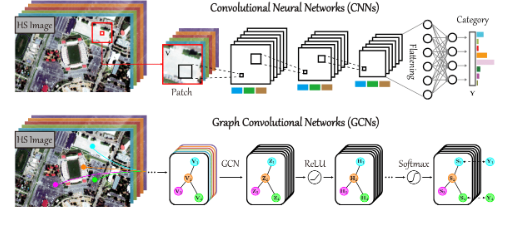

In [ ]:
hidden_features, out_features = 9, 1 # 2 = classifier predict
torch.manual_seed(0)
# create the model
gcn_model = GNNmodel('GCN', graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features, name='GCN')
print('Node feature dimension evolution {}->{}->{}'.format(graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features))

Node feature dimension evolution 4->9->1


### Start Training

In [ ]:
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.1)

2024-03-25 08:47:24 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 1 | 0.34569019079208374 | 0.28172364830970764 | 0.5377833333333333 | 0.5932
2024-03-25 08:47:33 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 2 | 0.2775722146034241 | 0.21338704228401184 | 0.5973 | 0.67585
2024-03-25 08:47:41 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 3 | 0.2101389616727829 | 0.19239039719104767 | 0.6804166666666667 | 0.71705
2024-03-25 08:47:49 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 4 | 0.19131621718406677 | 0.1831478625535965 | 0.7186 | 0.73725
2024-03-25 08:47:58 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 5 | 0.18279333412647247 | 0.17287735641002655 | 0.7365833333333334 | 0.7562
2024-03-25 08:48:07 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 6 | 0.1726970374584198 | 0.16494408249855042 | 0.7559166666666667 | 0.77015
2024-03-25 08:48:15 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 7 | 0.16471917927265167 | 0.16113506257534027 | 0.

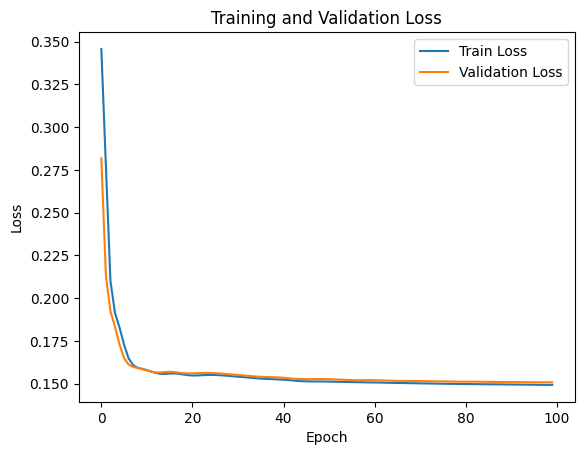

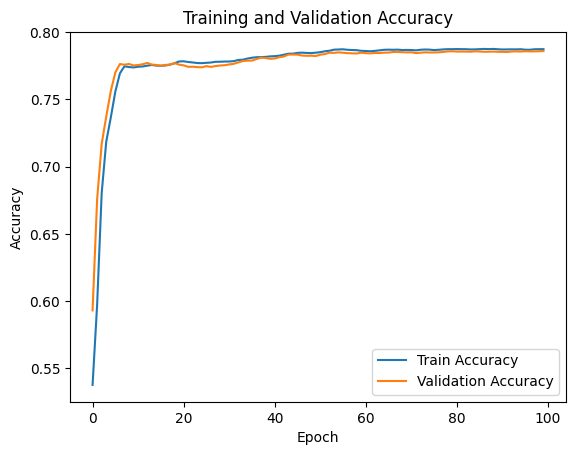

In [ ]:
losses = train(gcn_model, optimizer)

In [ ]:
# # load the last checkpoint with the best model.
# gcn_model.load_state_dict(torch.load(gcn_model.name+'.checkpoint'))
# save the model
torch.save(gcn_model, gcn_model.name)

### Test the model

In [ ]:
test_losses, train_pred, train_labels, val_pred, val_labels, test_pred, test_labels = test(gcn_model)

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, _ = roc_curve(train_labels, train_pred)
val_fpr, val_tpr, _ = roc_curve(val_labels, val_pred)
test_fpr, test_tpr, _ = roc_curve(test_labels, test_pred)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

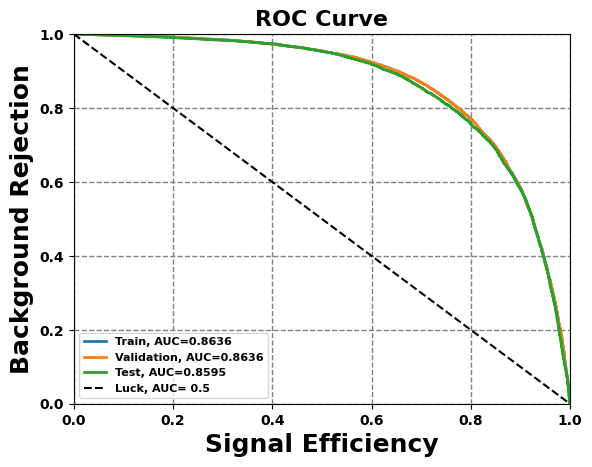

In [ ]:
plot_stacked_roc_curve([train_fpr, val_fpr, test_fpr], [train_tpr, val_tpr, test_tpr], labels=['Train', 'Validation', 'Test'])

## Architecture 2: Graph attention network.

GATs operate on a graph data structure similar to GCN. GATs introduce attention mechanisms to model the importance of neighboring nodes when updating a node's representation.
Attention mechanisms enable each node to focus on different neighbors based on previously learned attention weights.

for eah pair of nodes $v_i$ and $v_j$, attention coefficients are computed to determine the importance of node $v_j$ to node $v_i$

$$e_{ij} = a\left(W \cdot (h_i || h_j)\right)$$

where:
- $ h_i $ and $ h_j $ are the feature representations of nodes $ v_i $ and $ v_j $ respectively.
- $ || $ denotes concatenation.
- $ W $ is a learnable parameter matrix.
- $ a $ is an attention mechanism such as a multi-layer perceptron (MLP) with activation function like softmax.

we use soft-max so that attention coefficients sum up to 1.

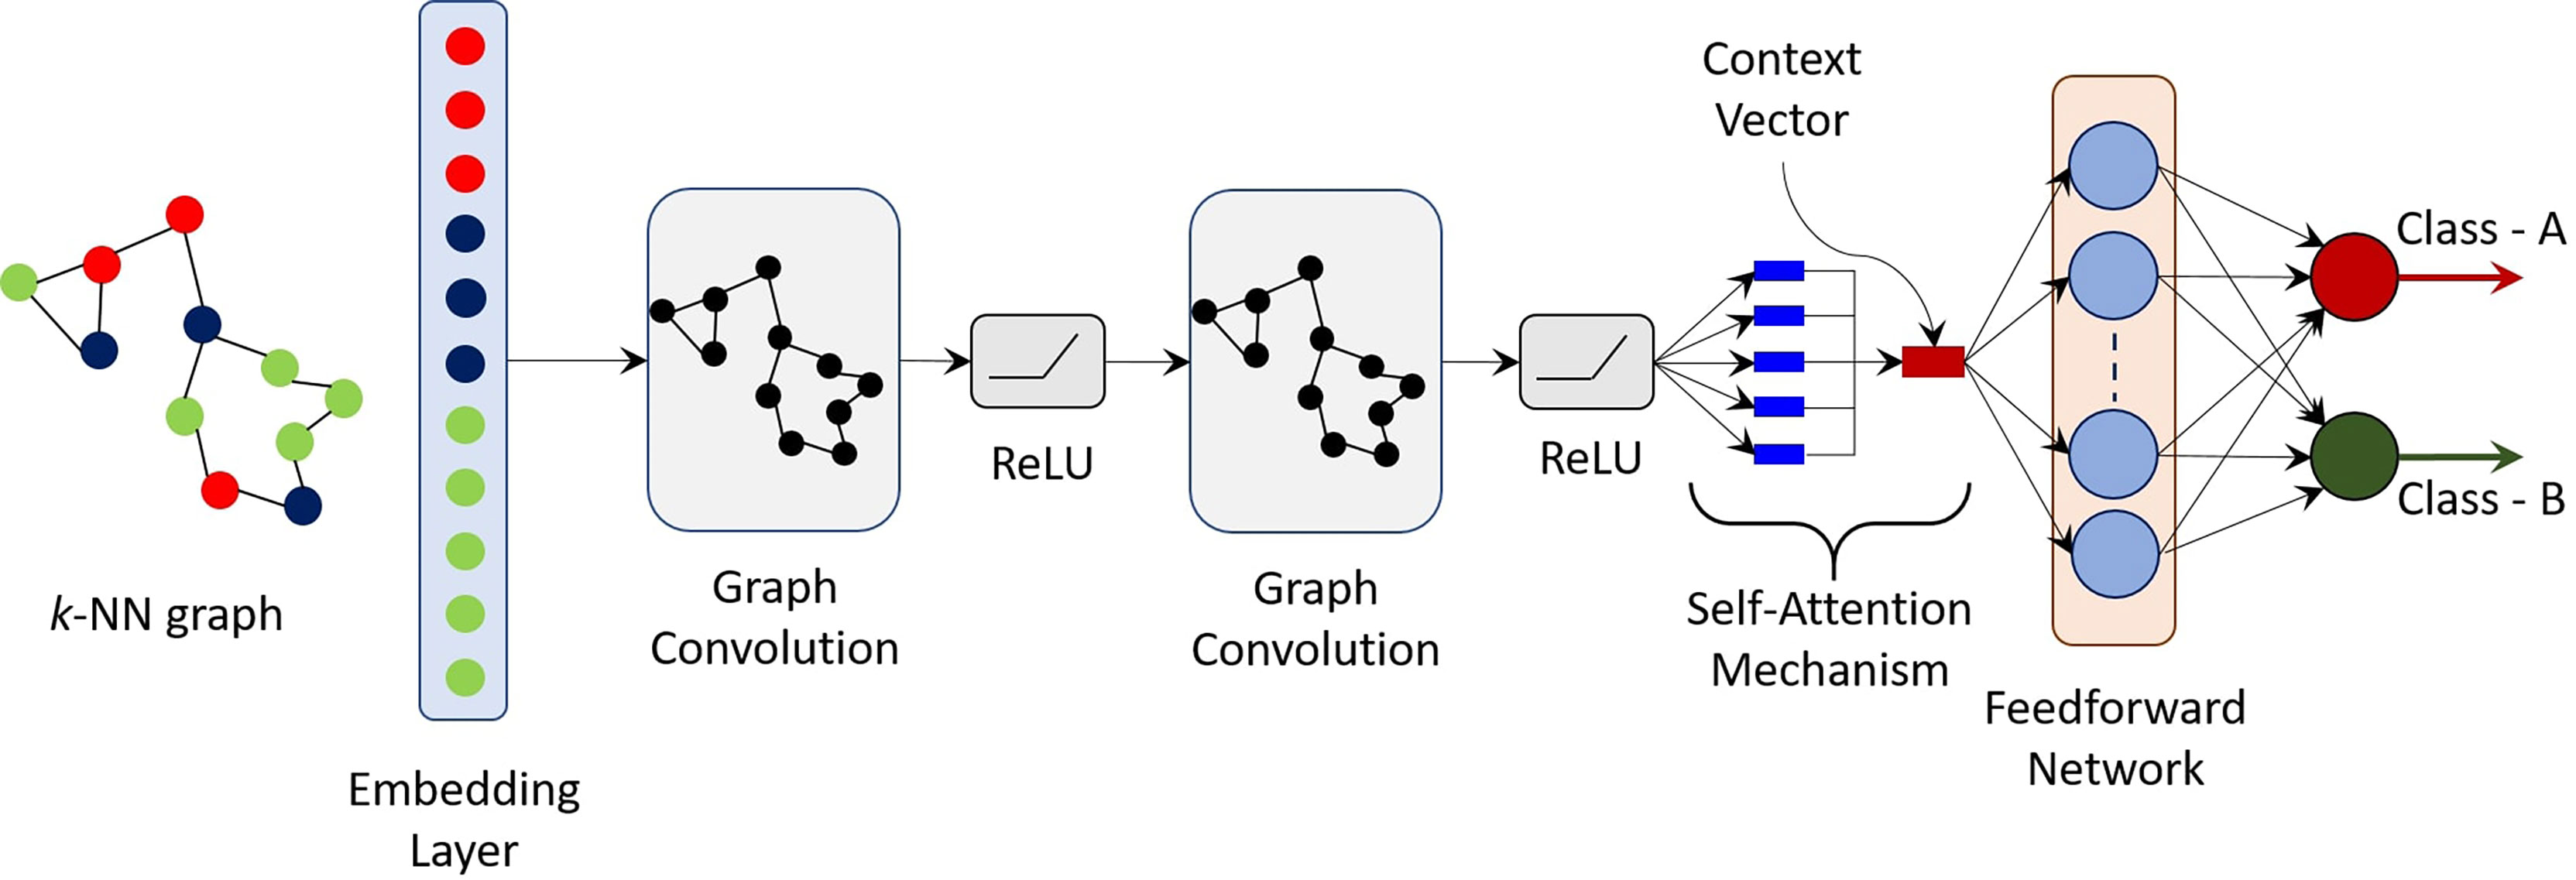


In [ ]:
hidden_features, out_features = 9, 1 # 2 = classifier predict
torch.manual_seed(0)
# create the model
gat_model = GNNmodel('GAT', graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features, name='GAT')
print('Node feature dimension evolution {}->{}->{}'.format(graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features))

Node feature dimension evolution 4->9->1


In [ ]:
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.1)

### Start training

2024-03-25 09:02:18 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 1 | 0.2504739463329315 | 0.2878199517726898 | 0.50125 | 0.49685
2024-03-25 09:02:31 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 2 | 0.2870703339576721 | 0.24975991249084473 | 0.4987333333333333 | 0.49715
2024-03-25 09:02:43 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 3 | 0.24955031275749207 | 0.2526995837688446 | 0.4991 | 0.5032
2024-03-25 09:02:56 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 4 | 0.2530035078525543 | 0.257678747177124 | 0.50125 | 0.5032
2024-03-25 09:03:09 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 5 | 0.258119136095047 | 0.25140881538391113 | 0.50125 | 0.5032
2024-03-25 09:03:22 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 6 | 0.25174564123153687 | 0.2456112802028656 | 0.50125 | 0.5032
2024-03-25 09:03:34 [INFO] epoch, loss, val_loss, accuracy, val_accuracy: 7 | 0.24574820697307587 | 0.24616196751594543 | 0.50125 | 0.5185
2024-03-25 09:03:47 [INFO

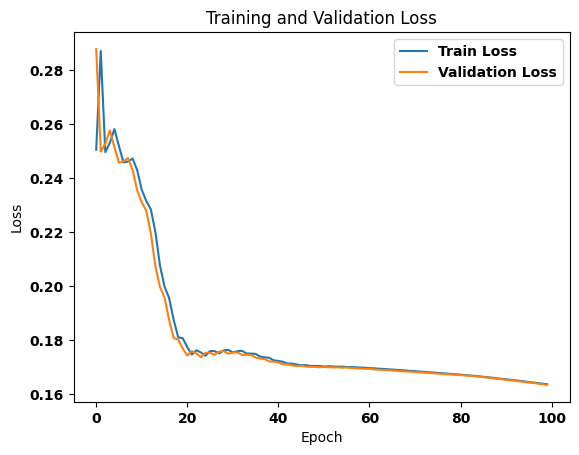

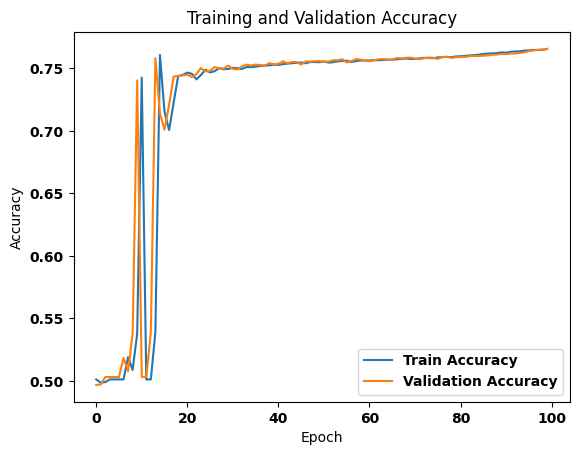

In [ ]:
losses_2 = train(gat_model, optimizer)

### Test the model

In [ ]:
test_losses2, train_pred2, train_labels2, val_pred2, val_labels2, test_pred2, test_labels2 = test(gat_model)

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr2, train_tpr2, _ = roc_curve(train_labels2, train_pred2)
val_fpr2, val_tpr2, _ = roc_curve(val_labels2, val_pred2)
test_fpr2, test_tpr2, _ = roc_curve(test_labels2, test_pred2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

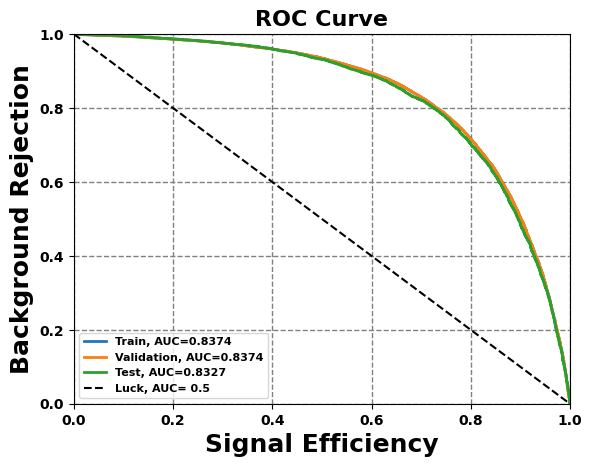

In [ ]:
plot_stacked_roc_curve([train_fpr2, val_fpr2, test_fpr2], [train_tpr2, val_tpr2, test_tpr2], labels=['Train', 'Validation', 'Test'])

## Results
**GCN:**
- Training Accuracy: 78.74%
- Validation Accuracy: 78.60%
- AUC: 0.8636

**GAT:**
- Training Accuracy: 76.57%
- Validation Accuracy: 76.57%
- AUC: 0.8374

The GCN model outperforms the GAT model in terms of accuracy and AUC on both training and validation datasets. and both the models are not overfitting

But the scores are lower in general mainly cause I've trained it on very less data. the dataset is huge.
but here are ways we can improve the graph models

GCN
- Adding more layers
- apply regularization like L2 or dropout
- optimize learning rates

GAT
- Increase Attention Heads
- Attention Mechanism Variants
- Layer Normalization

I've also gone through particleNet for this task.
